# README: Indian Ocean Heat Content and ENSO Index Analysis

This Jupyter Notebook calculates the **Ocean Heat Content (OHC)** of the Indian Ocean (50°E–100°E, 20°S–20°N, 0–700 m) using gridded ocean temperature data (EN4 dataset, 1950–2025), and compares it with the **Southern Oscillation Index (SOI)**, a commonly used El Niño/La Niña index.  

---

## Ocean Heat Content (OHC) Equation

The heat content of the ocean is estimated as:

$OHC = \int_{z_1}^{z_2} \int_{x_1}^{x_2} \int_{y_1}^{y_2} \rho \, c_p \, T(x,y,z,t) \, dx \, dy \, dz
$

where:  
- $\rho$ = density of seawater (~1025 kg/m³)  
- $c_p$ = specific heat capacity of seawater (~4096 J/kg°C)  
- $T(x,y,z,t$ = ocean temperature at location (x,y), depth (z), and time (t)  
- $dx, dy, dz$ = spatial grid spacing in longitude, latitude, and depth  

---

## Why Ocean Heat Content?

- OHC represents the **amount of heat stored in the ocean** and is a key metric for understanding **climate variability and change**.  
- More than **90% of excess heat from global warming** is stored in the oceans, making OHC one of the most important indicators of climate change.  
- Variability in OHC, especially in the **tropical Indian Ocean**, influences regional climate phenomena such as the **Indian monsoon**, **Indian Ocean Dipole (IOD)**, and its connection to **El Niño–Southern Oscillation (ENSO)**.  
- Comparing OHC with ENSO indices (like SOI) helps us understand the **teleconnections** between the Pacific and Indian Oceans.  

---

**Notebook Workflow:**  
1. Load EN4 gridded temperature dataset for the Indian Ocean.  
2. Subset data to 50°E–100°E, 20°S–20°N, 0–700 m.  
3. Compute OHC using seawater density and specific heat capacity.  
4. Calculate OHC anomalies relative to the mean.
5. Calculate the linear trend for the OHC anomaly for the period 1950-2025 & 2000-2025
6. Compare OHC anomalies with the Southern Oscillation Index (SOI).  
7. Visualize relationships between Indian Ocean OHC and ENSO.  


### Import libraries
This cell imports essential Python libraries: matplotlib (for plotting), cartopy (for geospatial plots), numpy (for numerical computing), and xarray (for handling NetCDF climate datasets).

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import math
from matplotlib.patches import Arc
import xarray as xr

### Open dataset
Loads EN4 ocean temperature dataset (1950–2025) for the Indian Ocean.

In [3]:
temp   =  xr.open_dataset('/home/rohit/Documents/data/EN4/EN4_IO_1950_2025.nc')

### Define constants
Defines seawater density (ρ = 1025 kg/m³) and specific heat capacity (cp = 4096 J/kg°C).

In [4]:
cp  =  4096   # J/(Kg C)
rho =  1025  # Kg/m^3 

### Subset temperature data
Extracts temperature between 50°E–100°E, 20°S–20°N, and depths 0–700 m for Indian Ocean OHC calculation.

In [5]:
tem = temp.TEMPERATURE.sel(LON30_120=slice(50,100),LAT54_114=slice(-20,20),DEPTH=slice(0,700))

### Compute Ocean Heat Content (OHC)
Integrates temperature over longitude, latitude, and depth. Multiplies by density and specific heat to calculate OHC.

In [6]:
OHC = (tem.fillna(0).integrate(["LON30_120","LAT54_114","DEPTH"])*cp*rho)#.plot()

### Mean OHC
Computes the long-term mean OHC for anomaly calculation.

In [7]:
OHC_mean = OHC.mean(dim="TIME")

### Plot OHC anomalies
Calculates anomalies (relative to mean OHC), converts to Petajoules and plots.

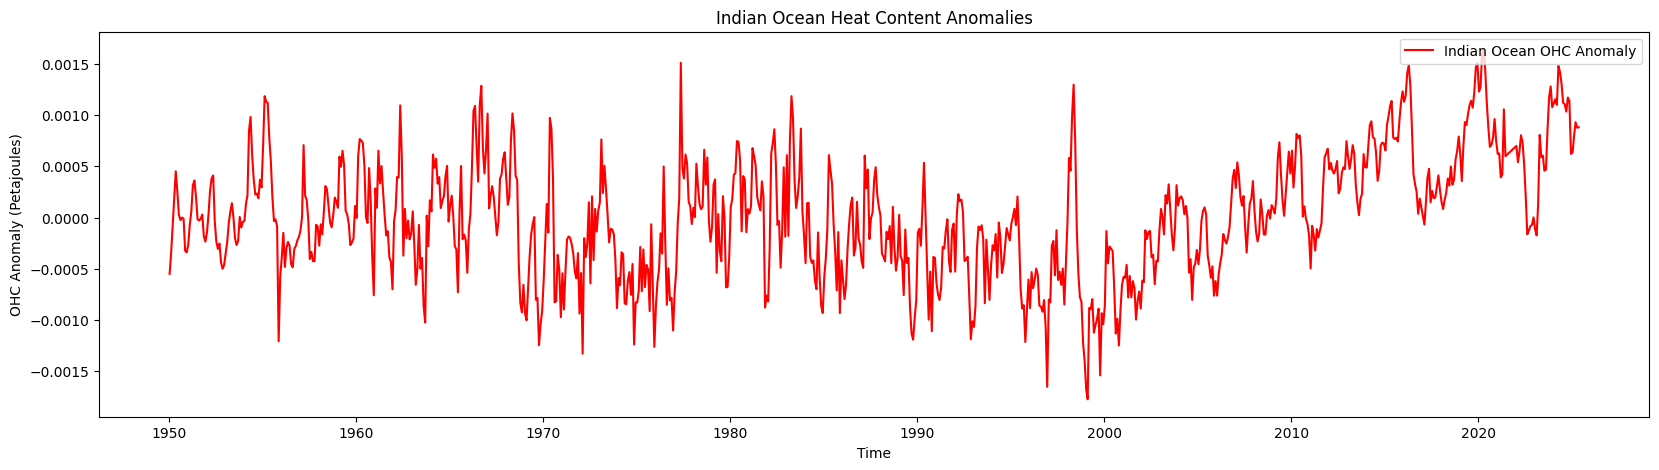

In [16]:
fig, ax = plt.subplots(figsize=(20,5))

# Plot OHC anomalies
((OHC - OHC_mean) / 1E15).plot(ax=ax, color='red', label="Indian Ocean OHC Anomaly")

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("OHC Anomaly (Petajoules)")
ax.set_title("Indian Ocean Heat Content Anomalies")

# Legend
ax.legend(loc="upper right")

plt.show()

### Plot smoothed OHC
Plots raw OHC values smoothed with a 12-month rolling mean.

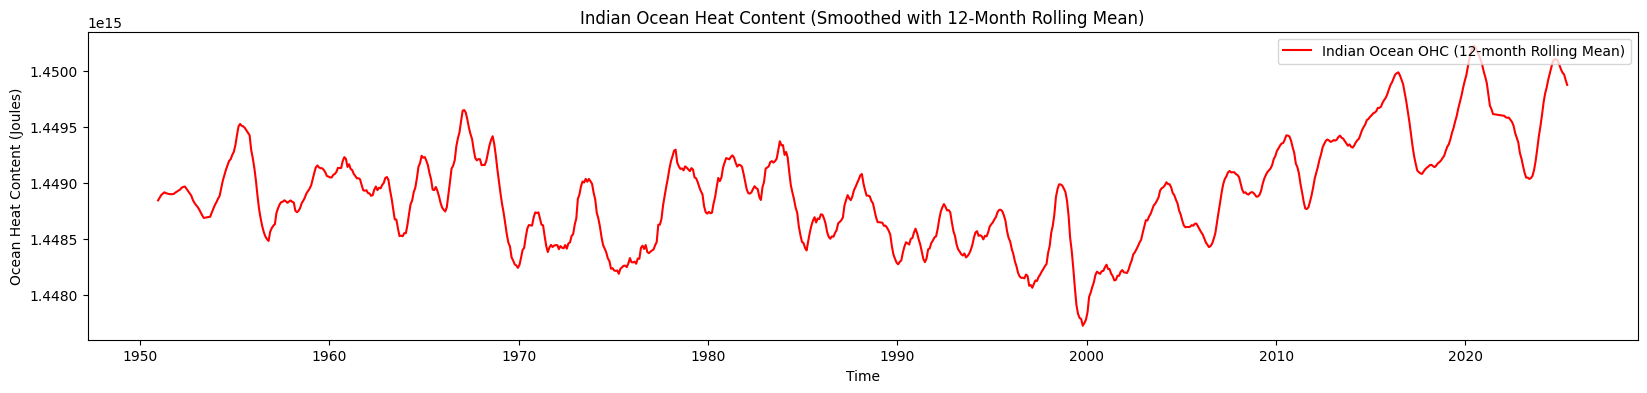

In [18]:
fig, ax = plt.subplots(figsize=(20,4))

# Plot rolling mean OHC
OHC.rolling(TIME=12).mean().plot(ax=ax, color='red', label="Indian Ocean OHC (12-month Rolling Mean)")

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Ocean Heat Content (Joules)")
ax.set_title("Indian Ocean Heat Content (Smoothed with 12-Month Rolling Mean)")

# Legend
ax.legend(loc="upper right")

plt.show()

### Linear Trend Analysis of Indian Ocean Heat Content
To quantify the long-term changes in ocean heat content (OHC), we compute linear trends using **ordinary least squares regression**:

1. **Full-period trend**:  
   Estimated over the entire available time series.  

2. **Sub-period trend (2000–2025)**:  
   Estimated only for the period from 2000 to 2025 to highlight recent changes.  

The time series is first smoothed using a **12-month rolling mean** to remove high-frequency variability.  
We then fit the linear model:

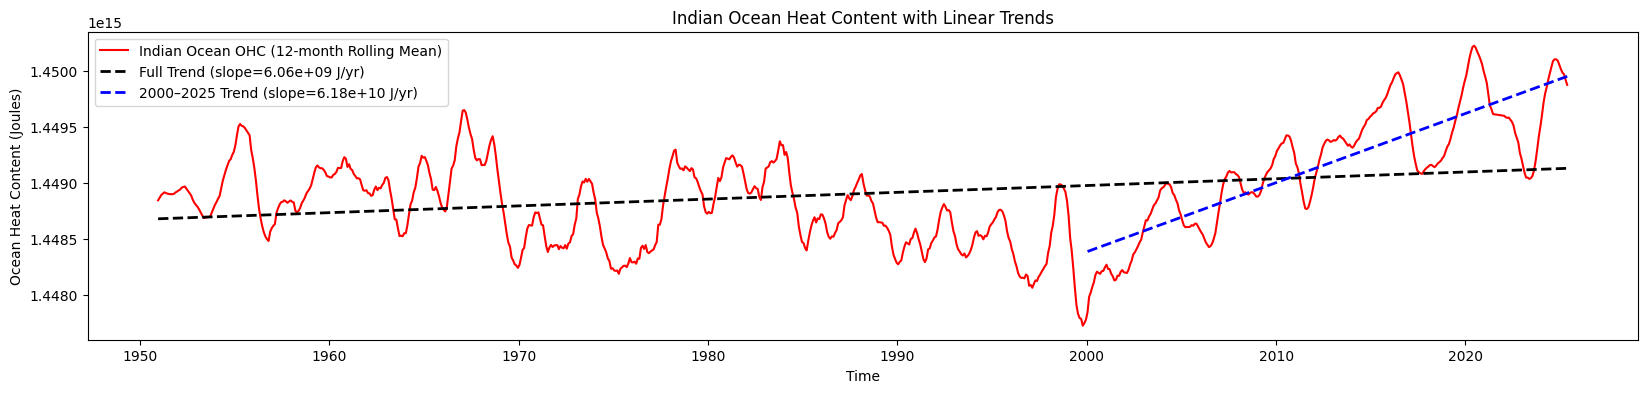

Full-period trend:
  Slope = 6.06e+09 J/year, R² = 0.08, p = 0.000

2000–2025 trend:
  Slope = 6.18e+10 J/year, R² = 0.70, p = 0.000


In [21]:
import numpy as np
from scipy.stats import linregress

# Apply rolling mean
ohc_smoothed = OHC.rolling(TIME=12).mean()

# Drop NaN values (from rolling window at the start)
ohc_valid = ohc_smoothed.dropna("TIME")

# Convert TIME to numeric (years)
years = ohc_valid.TIME.dt.year + (ohc_valid.TIME.dt.dayofyear / 365.0)

# ==============================
# 1. Full-period linear regression
# ==============================
slope_full, intercept_full, r_value_full, p_value_full, std_err_full = linregress(years, ohc_valid.values)
trend_full = intercept_full + slope_full * years

# ==============================
# 2. Sub-period (2000–2025) regression
# ==============================
mask_2000 = (ohc_valid.TIME.dt.year >= 2000) & (ohc_valid.TIME.dt.year <= 2025)
years_2000 = years[mask_2000]
ohc_2000 = ohc_valid.values[mask_2000]

slope_2000, intercept_2000, r_value_2000, p_value_2000, std_err_2000 = linregress(years_2000, ohc_2000)
trend_2000 = intercept_2000 + slope_2000 * years_2000

# ==============================
# Plot OHC with both trends
# ==============================
fig, ax = plt.subplots(figsize=(20,4))

# OHC time series
ax.plot(ohc_valid.TIME, ohc_valid, color='red', label="Indian Ocean OHC (12-month Rolling Mean)")

# Full-period trend line
ax.plot(ohc_valid.TIME, trend_full, color='black', linestyle="--", linewidth=2, 
        label=f"Full Trend (slope={slope_full:.2e} J/yr)")

# Sub-period trend line (2000–2025)
ax.plot(ohc_valid.TIME[mask_2000], trend_2000, color='blue', linestyle="--", linewidth=2, 
        label=f"2000–2025 Trend (slope={slope_2000:.2e} J/yr)")

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Ocean Heat Content (Joules)")
ax.set_title("Indian Ocean Heat Content with Linear Trends")

# Legend
ax.legend(loc="upper left")

plt.show()

# Print statistics
print("Full-period trend:")
print(f"  Slope = {slope_full:.2e} J/year, R² = {r_value_full**2:.2f}, p = {p_value_full:.3f}")
print("\n2000–2025 trend:")
print(f"  Slope = {slope_2000:.2e} J/year, R² = {r_value_2000**2:.2f}, p = {p_value_2000:.3f}")


### Load SOI Dataset  

The **Southern Oscillation Index (SOI)** is a standardized measure of the difference in sea level pressure (SLP) between **Tahiti** and **Darwin (Australia)**.  
It is one of the most widely used indices to monitor the **El Niño–Southern Oscillation (ENSO)** phenomenon.  

- **Positive SOI values** → Stronger-than-average trade winds, typically associated with **La Niña** conditions (cooler SSTs in the eastern Pacific).  
- **Negative SOI values** → Weaker trade winds, often associated with **El Niño** conditions (warmer SSTs in the eastern Pacific).  

In [11]:
soi = xr.open_dataset('/home/rohit/Downloads/soi.nc').SOI

### Plot of SOI index  

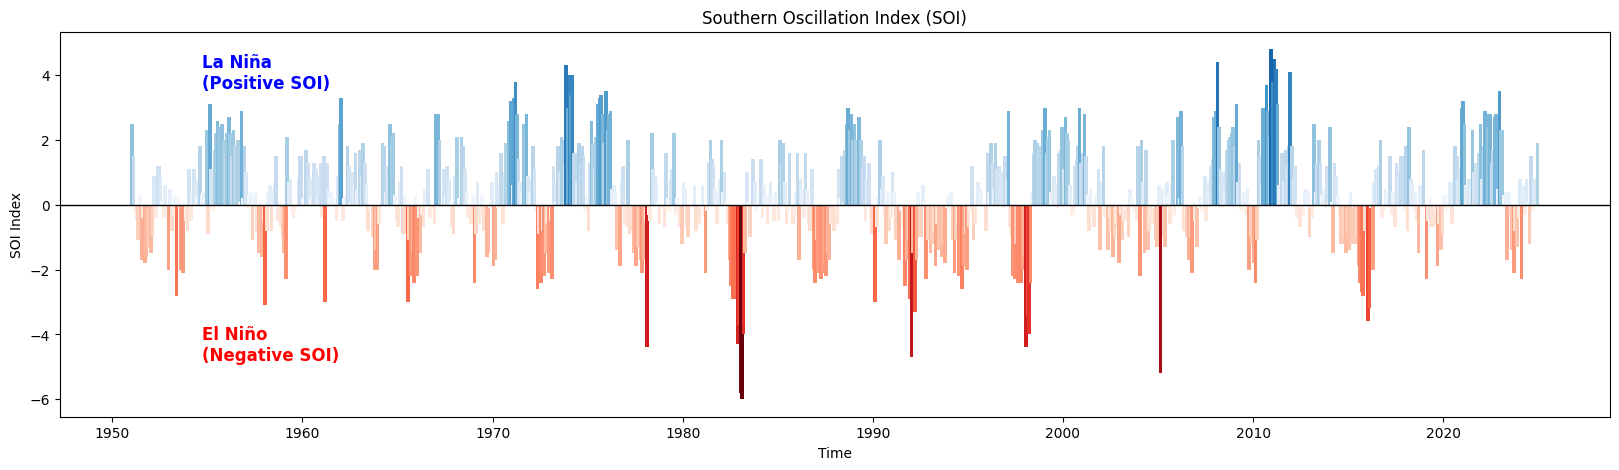

In [46]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20,5))

# Separate positive (blue) and negative (red) values
soi_values = soi.values
soi_time = soi['time'].values

# Normalize values for color intensity
max_val = np.max(np.abs(soi_values))
colors = [
    plt.cm.Blues(val/max_val) if val > 0 else plt.cm.Reds(abs(val)/max_val)
    for val in soi_values
]

# Plot bar chart with varying intensity
#ax.bar(soi_time, soi_values,width=)
ax.bar(soi_time, soi_values, color=colors, width=70.1)

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("SOI Index")
ax.set_title("Southern Oscillation Index (SOI)")

# Add horizontal line at zero
ax.axhline(0, color='black', linewidth=1)

# Add text labels for El Niño and La Niña
ax.text(soi_time[int(len(soi_time)*0.05)], -max_val*0.8, "El Niño\n(Negative SOI)", 
        color='red', fontsize=12, weight='bold')
ax.text(soi_time[int(len(soi_time)*0.05)], max_val*0.6, "La Niña\n(Positive SOI)", 
        color='blue', fontsize=12, weight='bold')

plt.show()


### Prepare comparison datasets
Computes OHC anomalies (Petajoules, smoothed) and SOI index (smoothed).

In [12]:
ohc    = ((OHC - OHC_mean)/1E15).rolling(TIME=12).mean() # Petta joules 
elnino = soi.rolling(time=12).mean()

### Dual-axis comparison plot
Plots OHC anomalies (red) and SOI index (blue) on shared time axis for ENSO comparison.

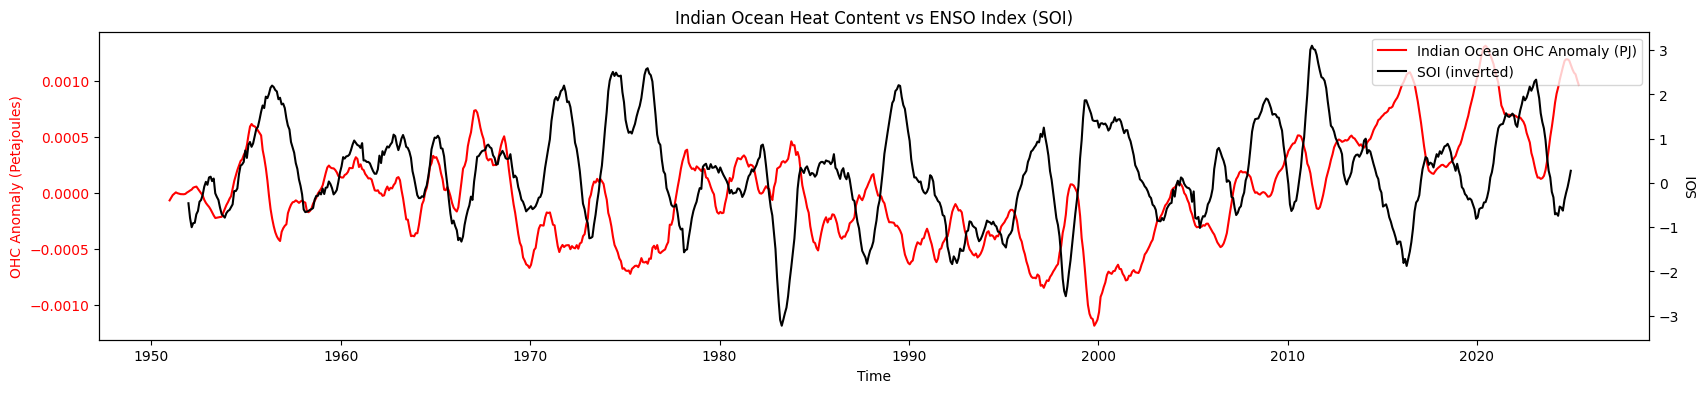

In [49]:
fig, ax1 = plt.subplots(figsize=(20,4))

# Plot OHC anomalies
ax1.plot(ohc.TIME, ohc, color='red', label="Indian Ocean OHC Anomaly (PJ)")
ax1.set_xlabel("Time")
ax1.set_ylabel("OHC Anomaly (Petajoules)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot SOI (inverted) on second axis
ax2 = ax1.twinx()
ax2.plot(elnino.time, elnino, color='black', label="SOI (inverted)")
ax2.set_ylabel("SOI", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Indian Ocean Heat Content vs ENSO Index (SOI)")
plt.show()

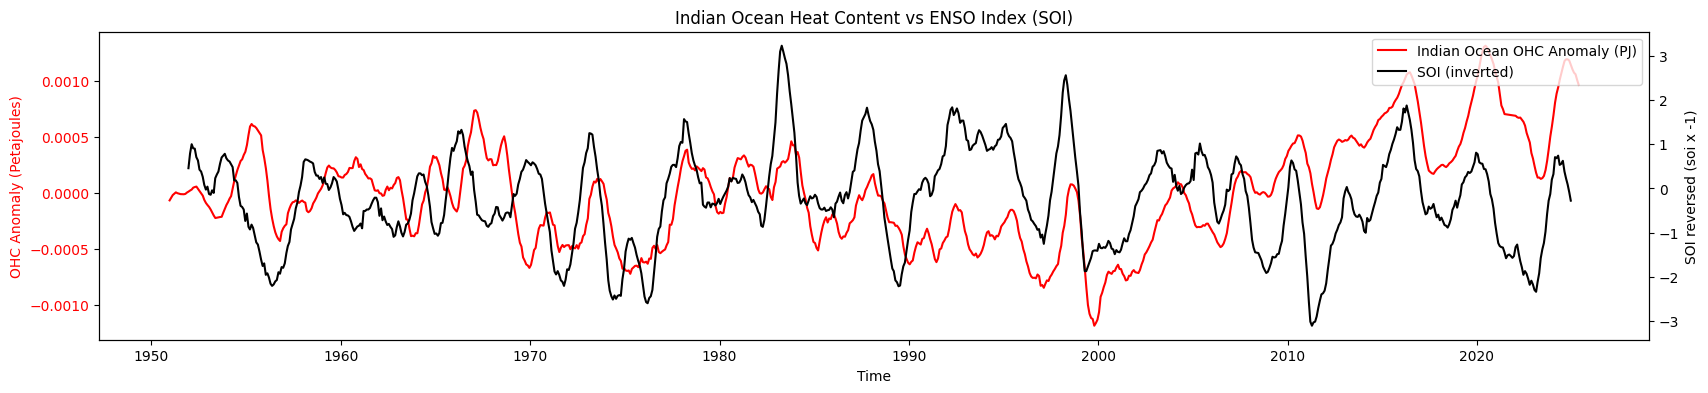

In [51]:
fig, ax1 = plt.subplots(figsize=(20,4))

# Plot OHC anomalies
ax1.plot(ohc.TIME, ohc, color='red', label="Indian Ocean OHC Anomaly (PJ)")
ax1.set_xlabel("Time")
ax1.set_ylabel("OHC Anomaly (Petajoules)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot SOI (inverted) on second axis
ax2 = ax1.twinx()
ax2.plot(elnino.time, elnino * -1, color='black', label="SOI (inverted)")
ax2.set_ylabel("SOI reversed (soi x -1)", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Indian Ocean Heat Content vs ENSO Index (SOI)")
plt.show()